## EDA and predictions on Titanic's dataset

В данной работе рассматривался набор данных, взятый с сайта kaggle.com. Над ним была произведена предобратка данных, небольшая часть исследовательского анализа, а также создание новых признаков. 

Также был рассмотрен тюнинг модели случайного леса для предсказания целевого признака (`Survived`). На тестовом наборе даннх метрика accuracy достигла 0.76.

Описание данных:
1. `PassengerId` - ID пассажира;
2. `Survived` - выжил ли пассажир или нет (0=нет, 1=да);
3. `Pclass` - класс билета;
4. `Name` - имя пассажира;
5. `Sex` - пол пассажира;
6. `Age` - возраст пассажира;
7. `SibSp` - количество братьев и сестёр/супругов на борту Титаника;
8. `Parch` - количество родителей/детей на борту Титаника;
9. `Ticket` - идентификатор билета;
10. `Fare` - затраты пассажира;
11. `Cabin` - номер каюты;
12. `Embarked` - порт посадки (C = Шербур, Q = Квинстаун, S = Саутгемптон).

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score as accuracy
import warnings 
warnings.filterwarnings('ignore')

### Первичный анализ данных

In [2]:
# Вывод основной информации о наборе данных
def ds_info(ds):
    print(f'Количество записей в данных: {ds.shape[0]}')
    print(f'Количество признаков:{ds.shape[1]}')
    print('-------------------------------------------')
    print('Основная информация о датасете:')
    print('')
    ds.info()
    print('-------------------------------------------')
    print('Структура данных:')
    display(ds.head())

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
ds_info(train_df)

Количество записей в данных: 891
Количество признаков:12
-------------------------------------------
Основная информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
-------------------------------------------
Структура данных:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
ds_info(test_df)

Количество записей в данных: 418
Количество признаков:11
-------------------------------------------
Основная информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
-------------------------------------------
Структура данных:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Предобработка данных

Предобработку данных начнем с поиска пропусков в `train_df`

In [6]:
pd.DataFrame(train_df.isna().mean(), index=train_df.columns, columns=['доля пропусков']).style.background_gradient()

,доля пропусков
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,0.198653
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


Заполним пропуски в столбце с возрастом. У пассажиров женского пола выделим две возрастные группы. Это можно сделать по приставке `Mrs` и `Miss`. Пропуски будем заполнять медианным значением. Создадим соответствующую функцию.

In [7]:
def female_nan(data):
    median_mrs = 0
    median_miss = 0
    mrs = []
    miss = []
    female = data[data['Sex'] == 'female'].\
             dropna(subset=['Age']).reset_index()
    for i in range(len(female)):                    # подсчет медианных значений
        if (('Mrs.' in female['Name'].loc[i]) | ('Ms.' in female['Name'].loc[i])):
            mrs.append(female['Age'].loc[i])
        if 'Miss.' in female['Name'].loc[i]:
            miss.append(female['Age'].loc[i])
    median_mrs = np.median(mrs)
    median_miss = np.median(miss)
    for i in range(len(data)):                  # заполнение пропущенных значений
        if ('Mrs.' in data['Name'].loc[i]) & (data['Age'].isna()[i] == True):
            data['Age'].loc[i] = median_mrs
        if (('Miss' in data['Name'].loc[i]) | ('Ms' in data['Name'].loc[i])) & (data['Age'].isna()[i] == True):
            data['Age'].loc[i] = median_miss
    return data

In [8]:
train_df = female_nan(train_df)

У пассажиров мужского пола выделим две возрастные группы. Это можно сделать по приставке `Mr` и `Master`. Пропуски будем заполнять медианным значением. Создадим соответствующую функцию.

In [9]:
def male_nan(data):
    median_mr = 0
    median_master = 0
    mr = []
    master = []
    male = train_df[train_df['Sex'] == 'male'].\
           dropna(subset=['Age']).reset_index()
    for i in range(len(male)):                    # подсчет медианных значений
        if 'Master.' in male['Name'].loc[i]:
            master.append(male['Age'].loc[i])
        if 'Mr.' in male['Name'].loc[i]:
            mr.append(male['Age'].loc[i])
    median_mr = np.median(mr)
    median_master = np.median(master)
    for i in range(len(data)):                  # заполнение пропущенных значений
        if ('Master.' in data['Name'].loc[i]) & (data['Age'].isna()[i] == True):
            data['Age'].loc[i] = median_master
        if (('Mr.' in data['Name'].loc[i]) | ('Master.' not in data['Name'].loc[i])) & (data['Age'].isna()[i] == True):
            data['Age'].loc[i] = median_mr
    return data

In [10]:
train_df = male_nan(train_df)

Удалим признак `Cabin` из-за большого количества пропусков, которые невозможно восстановить, а также неинформативности данного признака. Пропуски в `Embarked` заполним самым частым значением.

In [11]:
train_df = train_df.drop(columns=['Cabin'])
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].value_counts().index[0])

Проверим результат заполнения пропусков

In [12]:
pd.DataFrame(train_df.isna().mean(), index=train_df.columns, columns=['доля пропусков']).style.background_gradient()

,доля пропусков
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,0.000000
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


Аналогичную процедуру проведем для тестового набора данных. Проверим наличие пропусков.

In [13]:
pd.DataFrame(test_df.isna().mean(), index=test_df.columns, columns=['доля пропусков']).style.background_gradient()

,доля пропусков
PassengerId,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,0.205742
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.002392
Cabin,0.782297


In [14]:
test_df = female_nan(test_df)
test_df = male_nan(test_df)
test_df = test_df.drop(columns=['Cabin'])

Посмотрим на пропуски в столбце `Fare`, в котором отображены траты пассажиров

In [15]:
test_df[test_df['Fare'].isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


Заполним этот пропуск медианным значенем среди трат тех пассажиров, которые путешествовали тем же классом.

In [16]:
test_df['Fare'] = test_df['Fare'].fillna(test_df.groupby(by='Pclass').mean().loc[3]['Fare'])

Проверим теперь пропуски в тестовом наборе данных

In [17]:
pd.DataFrame(test_df.isna().mean(), index=test_df.columns, columns=['доля пропусков']).style.background_gradient()

,доля пропусков
PassengerId,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,0.000000
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000
Embarked,0.000000


Проверим также данные на дубликаты

In [18]:
print(f'Количество дубликатов в тренировочном наборе данных: {train_df.duplicated().sum()}')
print(f'Количество дубликатов в тестовом наборе данных: {test_df.duplicated().sum()}')

Количество дубликатов в тренировочном наборе данных: 0
Количество дубликатов в тестовом наборе данных: 0


### Анализ признаков набора данных

Посмотрим на распределение пассажиров по признаку выживаемости.

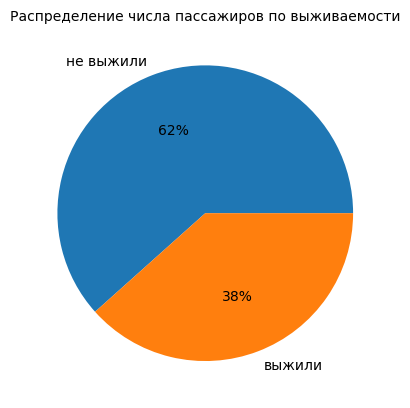

In [19]:
plt.pie(train_df['Survived'].value_counts(), labels=['не выжили', 'выжили'], autopct='%.0f%%')
plt.title('Распределение числа пассажиров по выживаемости', fontdict = {'fontsize' : 10})
plt.show()

Теперь посмотрим на выживаемость в отношении к полу пассажира

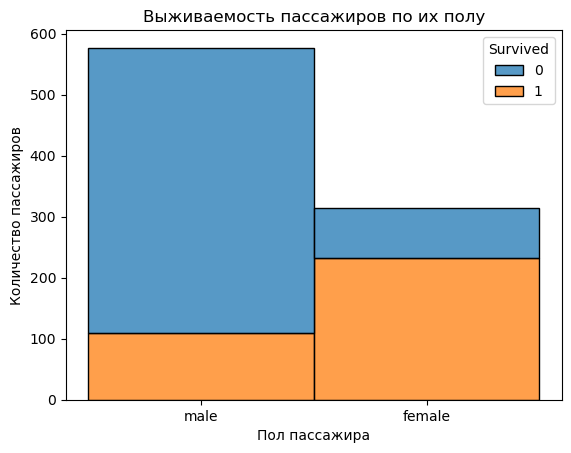

In [20]:
hist = sns.histplot(data=train_df, x="Sex", hue='Survived', multiple='stack')
hist.set(title='Выживаемость пассажиров по их полу', xlabel='Пол пассажира', ylabel='Количество пассажиров')
plt.show()

Поработаем с признаками тренировочного набора данных. Для начала удалим неинформативные признаки `PassengerId`, `Name`, `Ticket`, `Cabin`. Затем вместо признака `Age` введем признак `Age_cat`, который будет относить пассажира к той или иной возрастной категории.

In [21]:
# Функция для создания возрастных категорий
def new_age(data):
    data['Age_cat'] = np.ones(shape=(data.shape[0], 1))
    data['Age_cat'] = data['Age_cat'].where(data['Age'] >= 16, '0-15')
    data['Age_cat'] = data['Age_cat'].where((data['Age'] < 16) | (data['Age'] >= 25), '16-24')
    data['Age_cat'] = data['Age_cat'].where((data['Age'] < 25) | (data['Age'] >= 35), '25-34')
    data['Age_cat'] = data['Age_cat'].where((data['Age'] < 35) | (data['Age'] >= 50), '35-49')
    data['Age_cat'] = data['Age_cat'].where((data['Age'] < 50) | (data['Age'] >= 65), '50-64')
    data['Age_cat'] = data['Age_cat'].where((data['Age'] < 65), '65-...')
    data = data.drop(columns=['Age'])
    return data

In [22]:
train_df = train_df.drop(columns=['PassengerId', 'Name', 'Ticket'])
train_df = new_age(train_df)

Заменим также признаки `SibSp` и `Parch` на `Total_rel`, обозначающий общее число родственников на борту Титаника

In [23]:
train_df['Total_rel'] = train_df['SibSp'] + train_df['Parch']
train_df = train_df.drop(['SibSp', 'Parch'], axis=1)

Аналогичное изменение признаков проведем и в тестовом наборе данных

In [24]:
test_df_copy = test_df.copy()
test_df = test_df.drop(columns=['PassengerId', 'Name', 'Ticket'])
test_df = new_age(test_df)
test_df['Total_rel'] = test_df['SibSp'] + test_df['Parch']
test_df = test_df.drop(['SibSp', 'Parch'], axis=1)

Посмотрим на выживаемость по возратсным категориям

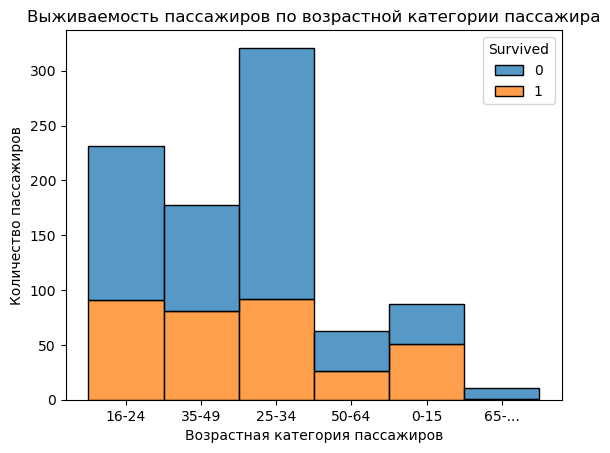

In [25]:
hist1 = sns.histplot(data=train_df, x="Age_cat", hue='Survived', multiple='stack')
hist1.set(title='Выживаемость пассажиров по возрастной категории пассажира', 
         xlabel='Возрастная категория пассажиров', ylabel='Количество пассажиров')
plt.show()

### Подбор гиперпараметров модели

Нам необходимо научиться предсказывать, погиб ли пассажир или нет. Выделим целевой признак `Survived`.

In [26]:
cat = ['Pclass', 'Sex', 'Embarked', 'Age_cat'] # категориальные данные
num = ['Fare', 'Total_rel'] # количественные признаки

In [27]:
train_features = train_df.drop(['Survived'], axis=1)
train_target = train_df['Survived']

Выделим категориальные и количественные признаки

In [28]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False), cat),
    ('num', StandardScaler(), num)
])

pipe_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=0, class_weight='balanced'))
])

Вначале используем RandomizedSearchCV для поиска наиболее лучших промежутков гиперпараметров

In [29]:
param_grid_rnd = {'model__n_estimators':range(1, 600, 49),
              'model__max_depth':range(1, 30),
              'model__criterion':['gini', 'entropy', 'log_loss'],
              'model__min_samples_split':range(2, 10),
              'model__min_samples_leaf':range(2, 10),
              'model__max_features':['sqrt', 'log2']}

grid_forest_rnd = RandomizedSearchCV(pipe_forest, param_grid_rnd, scoring='accuracy', 
                                     cv=5, n_iter=200, random_state=0, verbose=1)
grid_forest_rnd.fit(train_features, train_target)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['Pclass',
                                                                                'Sex',
                                                                                'Embarked',
                                                                                'Age_cat']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['Fare',
                                                                                'Total_rel'])])),
                                             ('model',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=0))]),
                   n_iter=200,
                   param_distributions={'model__criterion': ['gini', 'entropy',
                                                             'log_loss'],
                                        'model__max_depth': range(1, 30),
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_leaf': range(2, 10),
                                        'model__min_samples_split': range(2, 10),
                                        'model__n_estimators': range(1, 600, 49)},
                   random_state=0, scoring='accuracy', verbose=1)

Посмотрим на каких параметрах обучалась модель и какие метрики получала

In [30]:
table = pd.DataFrame(grid_forest_rnd.cv_results_).drop(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 
                                                       'split0_test_score', 'split1_test_score', 'split2_test_score', 
                                                       'split3_test_score', 'split4_test_score', 'std_test_score', 
                                                       'rank_test_score'], axis=1)
table.head()

,param_model__n_estimators,param_model__min_samples_split,param_model__min_samples_leaf,param_model__max_features,param_model__max_depth,param_model__criterion,params,mean_test_score
0,197,9,4,sqrt,27,gini,"{'model__n_estimators': 197, 'model__min_sampl...",0.804745
1,148,3,8,log2,13,log_loss,"{'model__n_estimators': 148, 'model__min_sampl...",0.796899
2,589,5,4,log2,29,entropy,"{'model__n_estimators': 589, 'model__min_sampl...",0.804727
3,442,8,4,log2,1,log_loss,"{'model__n_estimators': 442, 'model__min_sampl...",0.761001
4,148,8,5,sqrt,26,gini,"{'model__n_estimators': 148, 'model__min_sampl...",0.803622


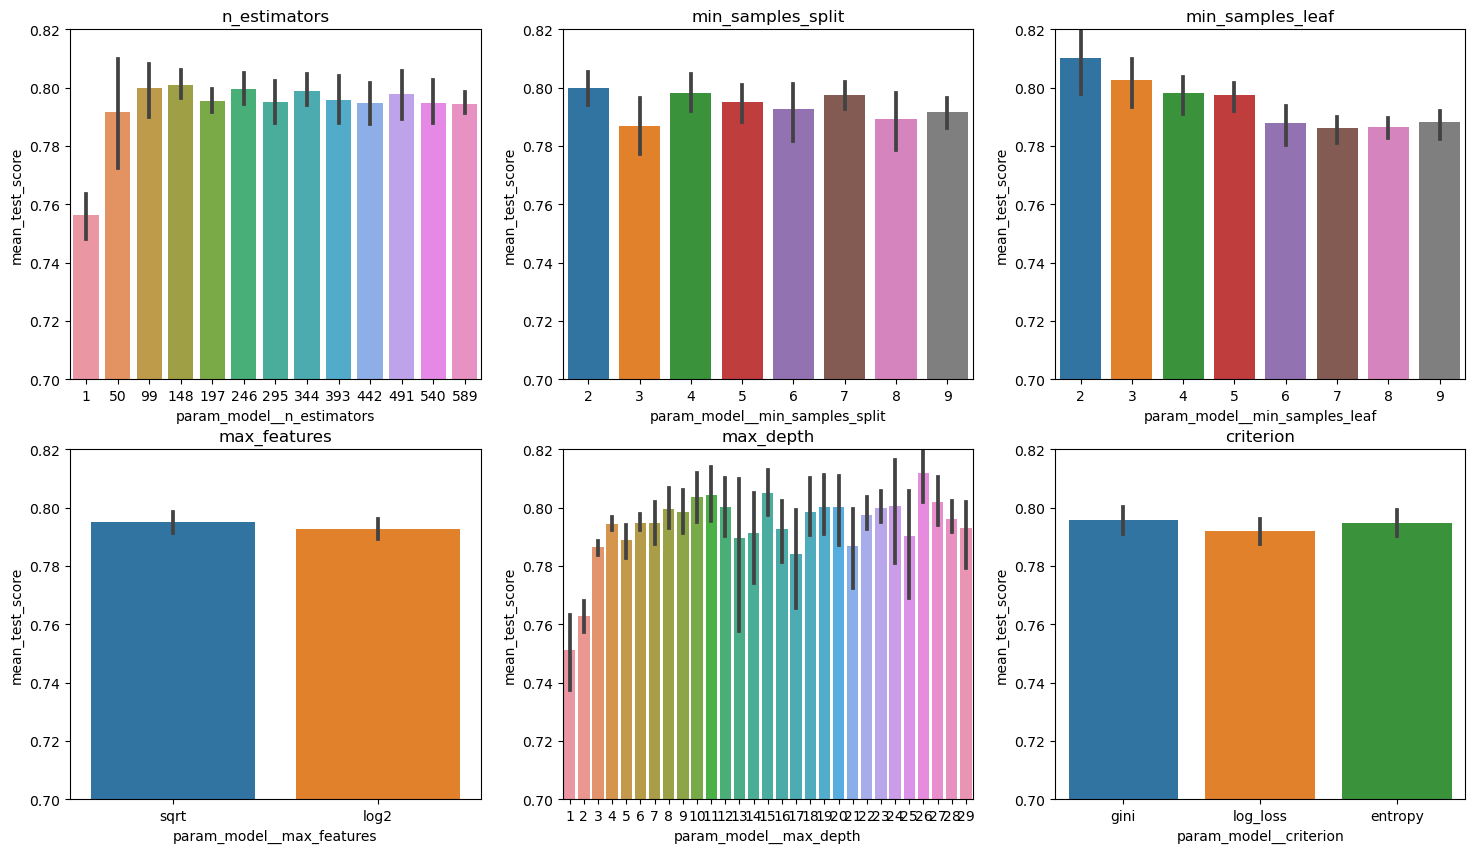

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
bar1 = sns.barplot(ax=axes[0, 0], data=table, x='param_model__n_estimators', y='mean_test_score')
bar1.set(ylim=(.7, .82), title='n_estimators')
bar2 = sns.barplot(ax=axes[0, 1], data=table, x='param_model__min_samples_split', y='mean_test_score')
bar2.set(ylim=(.7, .82), title='min_samples_split')
bar3 = sns.barplot(ax=axes[0, 2], data=table, x='param_model__min_samples_leaf', y='mean_test_score')
bar3.set(ylim=(.7, .82), title='min_samples_leaf')
bar4 = sns.barplot(ax=axes[1, 0], data=table, x='param_model__max_features', y='mean_test_score')
bar4.set(ylim=(.7, .82), title='max_features')
bar5 = sns.barplot(ax=axes[1, 1], data=table, x='param_model__max_depth', y='mean_test_score')
bar5.set(ylim=(.7, .82), title='max_depth')
bar6 = sns.barplot(ax=axes[1, 2], data=table, x='param_model__criterion', y='mean_test_score')
bar6.set(ylim=(.7, .82), title='criterion')
plt.show()

Сделаем некоторые комментарии. RandomizedSearchCV показал, что в рамках данной задачи для достижения наилучшего результата значение гиперпараметра `n_estimators` должно находится в промежутке от 50 до 150. Значения для `min_samples_split` рассмотрим следующие: 2, 4, 7. У гиперпараметра `min_samples_leaf` рассмотрим значения 2, 3, 4. Глубину каждого дерева подберем среди значений в промежутке от 8 до 26. Основываясь на этих выводах приступим к окончательному подбору параметров модели.

In [32]:
param_grid = {'model__n_estimators':range(40, 161, 20),
              'model__max_depth':range(8, 27, 2),
              'model__criterion':['gini', 'entropy'],
              'model__min_samples_split':[2, 4, 7],
              'model__min_samples_leaf':[2, 3, 4]}

grid_forest = GridSearchCV(pipe_forest, param_grid, scoring='accuracy', cv=5, verbose=1)
grid_forest.fit(train_features, train_target)
print(grid_forest.best_params_, grid_forest.best_score_)

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits
{'model__criterion': 'entropy', 'model__max_depth': 14, 'model__min_samples_leaf': 2, 'model__min_samples_split': 7, 'model__n_estimators': 120} 0.8316615403929445


In [33]:
grid_forest.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Age_cat']),
                                                 ('num', StandardScaler(),
                                                  ['Fare', 'Total_rel'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=14,
                                        min_samples_leaf=2, min_samples_split=7,
                                        n_estimators=120, random_state=0))])

In [34]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False), cat),
    ('num', StandardScaler(), num)
])

pipe_forest_test = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=14, min_samples_leaf=2, min_samples_split=7,
                       n_estimators=120, random_state=0))
])

In [35]:
pipe_forest_test.fit(train_features, train_target)
predict_train = pipe_forest_test.predict(train_df)
predict_test = pipe_forest_test.predict(test_df)

In [36]:
print('Метка accuracy на тренировочном наборе данных:', accuracy(train_target, predict_train))

Метка accuracy на тренировочном наборе данных: 0.8945005611672279


In [37]:
output = pd.DataFrame({'PassengerId': test_df_copy['PassengerId'], # Вывод предсказаний в csv файл
                       'Survived': predict_test}) 
output.to_csv('submission.csv', index=False)